In [1]:
cd S:\MangoMap

S:\MangoMap


In [2]:
!pip install -r requirements.txt

In [73]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from torch.optim import SGD
import shutil
import torch.nn as nn
import torch.nn.functional as F

In [74]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [75]:
os.makedirs(path,exist_ok = True)
os.makedirs(train_path,exist_ok = True)
os.makedirs(test_path,exist_ok = True)

In [76]:
#every class in Dataset
for class_name in os.listdir(dataset_path):
    
    class_path = os.path.join(dataset_path,class_name) #creating a path of current class example Langra class

    
    if os.path.isdir(class_path):  #check for current class is a directory or not
        images = [ f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path,f))] #making a list of all img file for that particular class (eg.Langra)
        size = len(images)
        threshold = int(size * (0.8))
        train_image = images[:threshold]   #splitting images into training and testing data
        test_image = images[threshold:]

    #making sub-directories for class_name
    
        train_class_dir = os.path.join(train_path,class_name) #path to train directory
        test_class_dir = os.path.join(test_path,class_name)  #path for test directory
        os.makedirs(train_class_dir,exist_ok = True) #creating directory from paths above
        os.makedirs(test_class_dir,exist_ok = True)

        for image in train_image:   #copying images from dataset to training directory
            src = os.path.join(dataset_path,class_name,image)
            dest = os.path.join(train_class_dir,image)
            shutil.copy(src,dest)
            
        for image in test_image: #copying images from dataset to testing directory
            src = os.path.join(dataset_path,class_name,image)
            dest = os.path.join(test_class_dir,image)
            shutil.copy(src,dest)        

In [77]:
#transformation for dataset

transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

In [78]:
dataset = datasets.ImageFolder(dataset_path,transform = transform)

In [79]:
dataloader = DataLoader(dataset,batch_size = 32,shuffle = True)

In [80]:
dataitem = iter(dataloader)
images,label = next(dataitem)

In [81]:
#mean and standard deviation calculation

m = torch.zeros(3)
std = torch.zeros(3)

for images,_ in dataloader:
    m += images.mean(dim=(0,2,3))
    std += images.mean(dim = (0,2,3))

m = m/len(dataloader)
std = std/len(dataloader)
m,std

(tensor([0.7192, 0.7178, 0.6538]), tensor([0.7192, 0.7178, 0.6538]))

In [98]:
#train transform and test transform
train_transform = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.RandomRotation(15),
                                     transforms.RandomHorizontalFlip(0.3),
                                     transforms.RandomVerticalFlip(0.3),
                                     transforms.ColorJitter(brightness = 0.2,contrast = 0.2,saturation = 0.2),
                                     transforms.ToTensor(),
                                     transforms.Normalize(m,std)])

test_transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(m,std)])

In [99]:
train_dataset = datasets.ImageFolder(train_path,transform = train_transform)
test_dataset = datasets.ImageFolder(test_path,transform = test_transform)

In [100]:
train_loader = DataLoader(train_dataset,batch_size = 16,shuffle = True)
test_loader = DataLoader(test_dataset,batch_size = 16,shuffle = True)

In [101]:
class_mango = []
for v,i in train_dataset.class_to_idx.items():  # Use .items() for dictionary
    class_mango.append(v)
class_mango

['Ashshina Zhinuk',
 'Bari -11',
 'Chausa',
 'Fazli',
 'Gourmati',
 'Harivanga',
 'Harumanis',
 'Katimon',
 'Langra']

In [102]:
dataitem = iter(train_loader)
images,labels = next(dataitem)

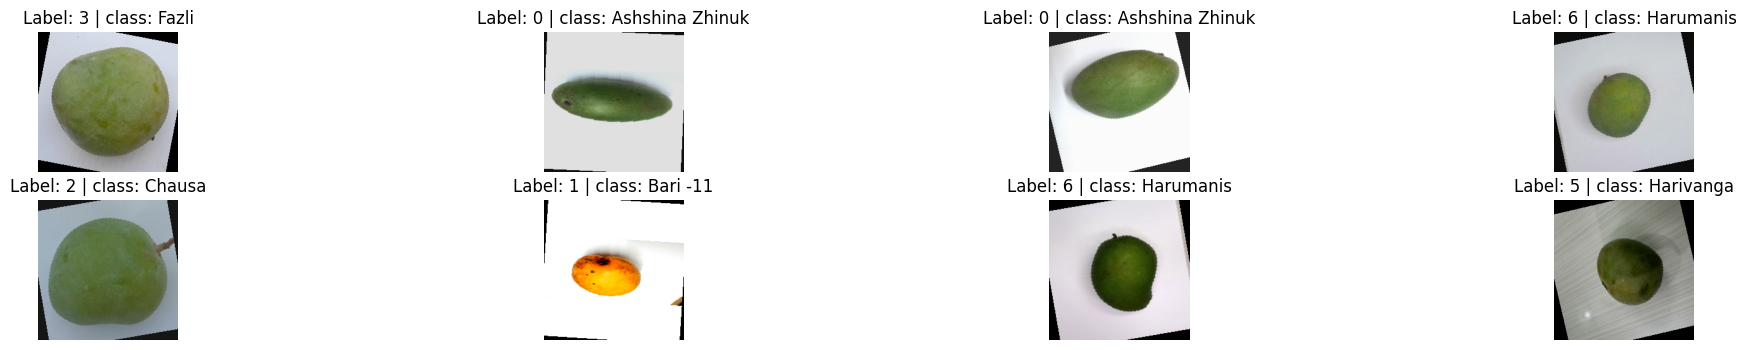

In [103]:
def denormalize(img,m,std):
    m = m[:,None,None]
    std = std[:,None,None]
    return (img*std)+m

fig,axes = plt.subplots(2,4,figsize = (25,4))
c = 0
for i in range (2):
    for j in range(4):
        img = denormalize(images[c],m,std)
        axes[i][j].imshow(img.permute(1,2,0).numpy())
        axes[i][j].axis('off')
        axes[i][j].set_title(f'Label: {labels[c]} | class: {class_mango[labels[c]]}')
        c+=1
plt.show()

In [104]:
#defining architecture of Model

class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3,16,5)
        self.conv2 = nn.Conv2d(16,32,5)
        self.pool = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(32*53*53,64)
        self.fc2 = nn.Linear(64,10)
        self.dropout = nn.Dropout(0.4)
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x),1)
        return x

In [117]:
#create an instance for Network
model = Network().to(device)

#Instance for a loss function

criteria = nn.CrossEntropyLoss()

#Instance for a Optimizer function

optimizer = SGD(model.parameters(),lr = 0.001)

For epoch: 1 train loss: 437.5888204574585 test loss: 96.30128061771393
For epoch: 2 train loss: 314.12941658496857 test loss: 82.73926186561584
For epoch: 3 train loss: 259.232896566391 test loss: 78.13118886947632
For epoch: 4 train loss: 226.28228968381882 test loss: 72.55254930257797
For epoch: 5 train loss: 195.4726164638996 test loss: 82.45349305868149
For epoch: 6 train loss: 175.45804539322853 test loss: 77.98517310619354
For epoch: 7 train loss: 159.06346780061722 test loss: 73.10421419143677
For epoch: 8 train loss: 147.57631394267082 test loss: 88.251944065094
For epoch: 9 train loss: 134.68477462232113 test loss: 82.20822855830193
For epoch: 10 train loss: 127.95115385949612 test loss: 75.98264521360397
For epoch: 11 train loss: 124.71563509106636 test loss: 86.60114753246307
For epoch: 12 train loss: 117.58030535280704 test loss: 82.89083543419838
For epoch: 13 train loss: 112.73101550340652 test loss: 84.28375774621964
For epoch: 14 train loss: 108.37963625788689 test los

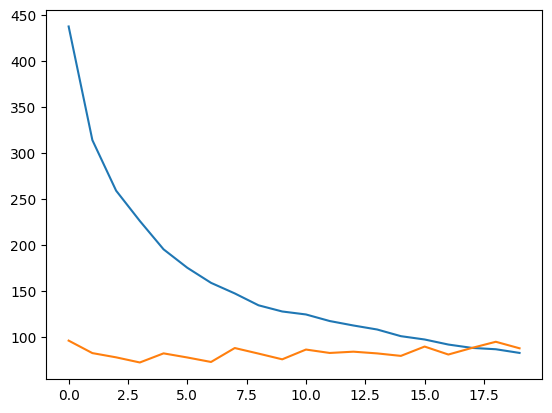

In [118]:
epochs = 20
train_loss_list = []
test_loss_list = []

for epoch in range(epochs):
    running_loss = 0
    test_loss = 0
    
    model.train()
    
    for images,labels in train_loader:

        images,labels = images.to(device),labels.to(device)
        
        #getting the ouputs form the model
        output  = model(images)

        #calculating Loss
        loss = criteria(output,labels)

        #turning previous gradients to zero
        optimizer.zero_grad()

        #backpropogating to calculate gradient
        loss.backward()

        #taking step for optimization
        optimizer.step()
        
        running_loss +=loss.item()

    train_loss_list.append(running_loss)

    model.eval()
    
    for images,labels in test_loader:

        images,labels = images.to(device),labels.to(device)

        output = model(images)

        loss = criteria(output,labels)

        test_loss += loss.item()

    test_loss_list.append(test_loss)
    print(f"For epoch: {epoch+1} train loss: {running_loss} test loss: {test_loss}")

correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"The accuracy of model is: {accuracy}%")

plt.plot(range(epochs),train_loss_list)
plt.plot(range(epochs),test_loss_list)